In [1]:
import tnw_cate as tc
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tensorflow.config import set_visible_devices
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.initializers import GlorotNormal
from utility import make_spec_set, calc_mse
from other_models import KernelRegression, MyForest
from funcs import Spiral_linear, get_pow_setup
from treatment_frameworks import *
from utility import *
from other_models import *


seed = 12345
set_visible_devices([], 'GPU')
set_random_seed(seed)
initializer = GlorotNormal(seed=seed)
np.seterr(invalid='ignore')
gamma = [10 ** i for i in range(-8, 11)] + [0.5, 5, 50, 100, 200, 500, 700]

# Examples of the regression mechanism itself

## Reproducing the Gaussian kernel 

Using trainable kernel with the uniform distribution produces kernel structure similar with the Gaussian one.

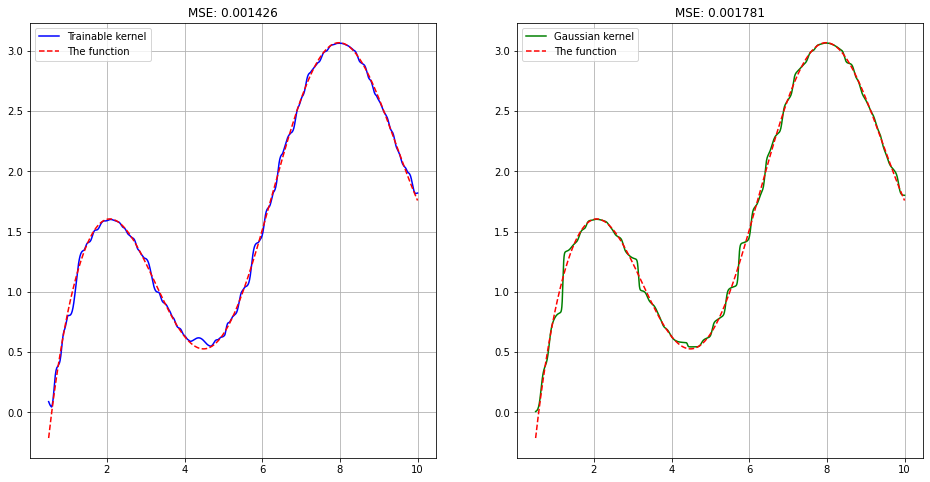

In [2]:
func = lambda x: (np.log(x) + np.sin(x)).ravel()

# train samples num is 100
x_train = np.random.uniform(0.5, 10, (100, 1))
x_val = np.random.uniform(0.5, 10, (20, 1))
x_plot = np.linspace(0.5, 10, 1000)[:, np.newaxis]

y_train, y_val, y_plot = func(x_train), func(x_val), func(x_plot)

nw_model = KernelRegression(gamma=gamma)
nw_model.set_val(x_val, y_val)
nw_model.fit(x_train, y_train)

topology = [
            {'units': 10, 'activation': 'tanh', 'kernel_initializer': initializer},
            {'units': 4, 'activation': 'tanh', 'kernel_initializer': initializer},
            {'units': 1, 'activation': 'softplus', 'kernel_initializer': initializer}
        ]
*tnw_val_x, tnw_val_y = make_spec_set(x_train, x_val, y_train, y_val, 80, 1, 500)
tnw_model_static, _ = tc.train_kernel(x_train, y_train, 80, 1, 2000, 100, (tnw_val_x, tnw_val_y), seed, 256, 5, 0.005, topology, verbose=0)
tnw_model = tc.DynamicModel(tnw_model_static, False)

*tnw_plot_x, tnw_plot_y = make_spec_set(x_train, x_plot, y_train, y_plot, 100, 1, 1)
tnw_predict = tnw_model.predict(tnw_plot_x)
nw_predict = nw_model.predict(x_plot)

_, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].plot(tnw_plot_x[2], tnw_predict, 'b', label='Trainable kernel')
axes[0].set_title(f'MSE: {round(calc_mse(tnw_plot_y, tnw_predict), 6)}')
axes[1].plot(x_plot, nw_predict, 'g', label='Gaussian kernel')
axes[1].set_title(f'MSE: {round(calc_mse(y_plot, nw_predict), 6)}')
for i in range(2):
    axes[i].plot(x_plot, y_plot, 'r--', label='The function')
    axes[i].grid()
    axes[i].legend()
plt.show()

## Using special feature distribution

All predictors are located on the Archimedean spiral. The response is linear.

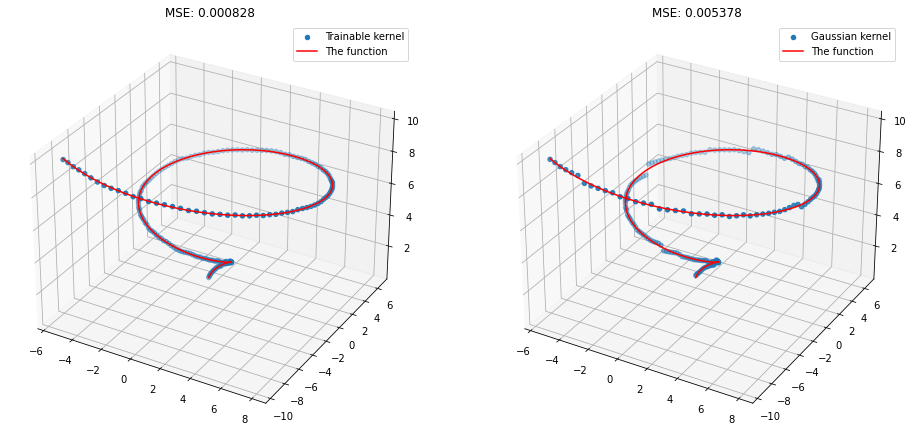

In [3]:
func = Spiral_linear((0, 1), 2)

# train samples num is 100
t_train = np.random.uniform(0, 10, 100)
x_train, y_train = func.calc_x(t_train), func.calc_y(t_train)
t_plot = np.linspace(0, 10, 200)
x_plot, y_plot = func.calc_x(t_plot), func.calc_y(t_plot)
t_val = np.random.uniform(0, 10, 50)
x_val, y_val = func.calc_x(t_val), func.calc_y(t_val)


nw_model = KernelRegression(gamma=gamma)
nw_model.set_val(x_val, y_val)
nw_model.fit(x_train, y_train)

topology = [
            {'units': 10, 'activation': 'tanh', 'kernel_initializer': initializer},
            {'units': 4, 'activation': 'tanh', 'kernel_initializer': initializer},
            {'units': 1, 'activation': 'softplus', 'kernel_initializer': initializer}
        ]
*tnw_val_x, tnw_val_y = make_spec_set(x_train, x_val, y_train, y_val, 80, 2, 500)
tnw_model_static, _ = tc.train_kernel(x_train, y_train, 80, 2, 2000, 100, (tnw_val_x, tnw_val_y), seed, 256, 20, 0.005, topology, verbose=0)
tnw_model = tc.DynamicModel(tnw_model_static, False)

*tnw_plot_x, tnw_plot_y = make_spec_set(x_train, x_plot, y_train, y_plot, 100, 2, 1)
tnw_predict = tnw_model.predict(tnw_plot_x)
nw_predict = nw_model.predict(x_plot)

_, axes = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': '3d'})
axes[0].scatter(tnw_plot_x[2][:, 0], tnw_plot_x[2][:, 1], tnw_predict, 'b', label='Trainable kernel')
axes[0].set_title(f'MSE: {round(calc_mse(tnw_plot_y, tnw_predict), 6)}')
axes[1].scatter(x_plot[:, 0], x_plot[:, 1], nw_predict, 'g', label='Gaussian kernel')
axes[1].set_title(f'MSE: {round(calc_mse(y_plot, nw_predict), 6)}')
for i in range(2):
    axes[i].plot(x_plot[:, 0], x_plot[:, 1], y_plot, 'r', label='The function', zorder=10)
    axes[i].grid()
    axes[i].legend()
plt.show()

# Example with the CATE prediction

This block is similar with the experiment, which generates table results.

In [4]:
alpha = 1
batch_size = 256
learning_rate_a = 0.002
learning_rate = 0.01
epochs_num_alpha = 100
epochs_num_ordinary = 50
patience = 5
m = 20
tasks = 200000

control_size = 100
treat_part = 0.1
test_size = 1000
treat_size = int(treat_part * control_size)

mlp_coef = 200000 // control_size
n = 100 if control_size > 100 else 80
n_t = treat_size // 2
n_c = n_t
mlp_coef_val = 500

trees = [10, 50, 100, 300]
depth = [2, 3, 4, 5, 6, 7]
leaf_samples = [1, 0.05, 0.1, 0.2]

results = defaultdict(list)

setup = get_pow_setup(m)
setup.make_set(control_size, treat_part, test_size)
train_x, train_y, train_w = setup.get_train_set()
control_x, control_y, treat_x, treat_y = setup.get_cotrol_treat_sets()
test_x, test_control, test_treat,  test_cate = setup.get_test_set()
val_set_c, val_labels_c, val_set_t, val_labels_t = setup.get_val_set()

model = get_basic_dynamic_model(setup, m, n, epochs_num_ordinary, mlp_coef, mlp_coef_val, learning_rate, seed, batch_size, patience, 0)

*test_data_control, cnt_label = make_spec_set(control_x, test_x, control_y, test_control, control_size, m, 1)
*test_data_treat, trt_label = make_spec_set(treat_x, test_x, treat_y, test_treat, treat_size, m, 1)
cnt_pred = model.predict(test_data_control)
results['TNW-CATE control'].append(calc_mse(cnt_pred, cnt_label))

alpha_model = get_alpha_dynamic_model(setup, m, n_c, n_t, epochs_num_alpha, mlp_coef_val, learning_rate, seed, batch_size, tasks, alpha, patience, 0)
trt_pred_a = alpha_model.predict(test_data_treat)
results['TNW-CATE treat'].append(calc_mse(trt_pred_a, trt_label))
results['TNW-CATE CATE'].append(calc_mse(trt_pred_a - cnt_pred, trt_label - cnt_label))

other_models = {
    'T-Learner': (make_t_learner, (val_set_c, val_labels_c, None, None, MyForest, trees, depth, leaf_samples), (train_x, train_y, train_w)),
    'S-Learner': (make_s_learner, (val_set_c, val_labels_c, None, None, MyForest, trees, depth, leaf_samples), (train_x, train_y, train_w)),
    'X-Learner': (make_x_learner, (val_set_c, val_labels_c, None, None, MyForest, trees, depth, leaf_samples), (train_x, train_y, train_w)),
    'T-NW': (make_t_learner, (val_set_c, val_labels_c, None, None, KernelRegression, 'rbf', gamma), (train_x, train_y, train_w)),
    'S-NW': (make_s_learner, (val_set_c, val_labels_c, None, None, KernelRegression, 'rbf', gamma), (train_x, train_y, train_w)),
    'X-NW': (make_x_learner, (val_set_c, val_labels_c, None, None, KernelRegression, 'rbf', gamma), (train_x, train_y, train_w))
}

for key, val in other_models.items():
    instance = val[0](*val[1])
    instance.fit(*val[2])
    if (hasattr(instance, 'predict_control')):
        control_pred = instance.predict_control(test_x)
        results[f'{key} control mse'].append(calc_mse(control_pred, test_control))
    if (hasattr(instance, 'predict_treat')):
        treat_pred = instance.predict_treat(test_x)
        results[f'{key} treat mse'].append(calc_mse(treat_pred, test_treat))
    cate_pred = instance.predict(test_x)
    results[f'{key} CATE mse'].append(calc_mse(cate_pred, test_cate))

print('result:')
for key, val in results.items():
    print(key, ': ', round(np.mean(val), 6))

result:
TNW-CATE control :  0.001658
TNW-CATE treat :  0.165826
TNW-CATE CATE :  0.17055
T-Learner control mse :  0.004634
T-Learner treat mse :  2.216381
T-Learner CATE mse :  2.194969
S-Learner control mse :  0.014006
S-Learner treat mse :  1.19822
S-Learner CATE mse :  1.2755
X-Learner CATE mse :  0.454669
T-NW control mse :  0.155574
T-NW treat mse :  1.489235
T-NW CATE mse :  1.158397
S-NW control mse :  0.159425
S-NW treat mse :  1.070825
S-NW CATE mse :  0.835597
X-NW CATE mse :  0.420691
